## 1. Import packages

In [1]:
#%env OMP_NUM_THREADS=8
import sys
sys.path.append('../src/')
import copy

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.patches import Patch

import numpy as np
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import autoencoder as ae

random_state = 150
torch.manual_seed(random_state);


from computational_utils import reshape

from io_work import stringSplitByNumbers

import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from computational_utils import reshape
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

/home/hariyuki/apd/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## 2. Load data

In [2]:
data_dirname = '../data/'
data_filename = 'dataset_without_moc.npz'
data_filename2 = 'full_dataset_autoencoded.npz'
label_plant_filename = 'species.csv'

df = np.load(data_dirname+data_filename)
data, labels = df['data'], df['label']
data = reshape(data, [data.shape[0], -1])
data /= np.linalg.norm(data, axis=1, keepdims=True)

df = np.load(data_dirname+data_filename2)
data_ae = df['data']
data_ae /= np.linalg.norm(data_ae, axis=1, keepdims=True)

label_plant_dict = pd.read_csv(data_dirname+label_plant_filename, index_col=0, header=None)
label_plant_dict = label_plant_dict.to_dict()[1]

uni_labels = np.unique(labels)

# this part stands for negative class marking
min_count = 20
y = labels.copy()
uni_y, counts = np.unique(y, return_counts=True)
ind = counts < min_count
for value in uni_y[ind]:
    y[y == value] = -1
y[y != -1] = 0

uni_y[ind] = -1


## 3. Colour palette

Define custom colour palette. We tried to use colours which are as much different as possible.

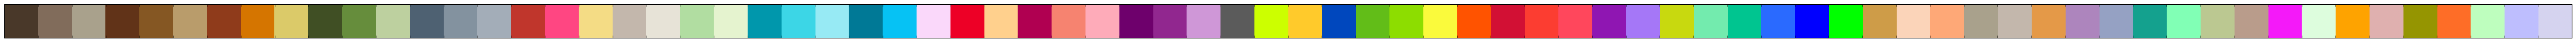

In [3]:
colour_palette = [
    '#493829', '#816C5B', '#A9A18C', '#613318', '#855723', '#B99C6B', '#8F3B1B', '#D57500',
    '#DBCA69', '#404F24', '#668D3C', '#BDD09F', '#4E6172', '#83929F', '#A3ADB8', '#C0362C',
    '#FF4682', '#F4DC85', '#C3B7AC', '#E7E3D7', '#B1DDA1', '#E5F3CF', '#0097AC', '#3CD6E6',
    '#97EAF4', '#007996', '#06C2F4', '#FAD8FA', '#ED0026', '#FFD08D', '#B00051', '#F68370',
    '#FEABB9', '#6E006C', '#91278F', '#CF97D7', '#5B5B5B', '#CCFF00', '#FFCA2B', '#0047BD',
    '#62BD18', '#8DDD00', '#FAFA3C', '#FF5300', '#D21034', '#FC3D31', '#FF475C', '#8F16B2',
    '#A577F7', '#C8D90F', '#73EBAE', '#00C590', '#2A6AFF', '#0000FF', '#00FF00', '#CE9C48',
    '#FBD4B9', '#FEA877', '#A9A18C', '#C3B7AC', '#E49948', '#AD85BD', '#95A1C3', '#14A18E',
    '#81FFB5', '#BBC891', '#B99C8B', '#F419F9', '#DDFDDD', '#FEA300', '#DFB0AF', '#959501',
    '#FE6D27', '#BEFEBE', '#BEBEFE', '#D5D3EF'
    #'#668D3C', '#5A0089', '#5AA08D', '#695D54', '#003E51', '#87A6AD', '#C8CAC0', '#BEB2A7',
    #'#E55300', '#FF2B00', '#FF8106', '#B5F923', '#29568F', '#9EE7FA', '#8042B5', '#FF7200',
    #'#FFA715', '#A3EE3F', '#FFBB00', '#FFCE00', '#FF822A', '#EA0034', '#006884', '#00909E',
    #'#89DBEC', '#FA9D06'   
]

sns.palplot(sns.color_palette(colour_palette))
#sns.palplot(sns.hls_palette(60, l=.3, s=.8))

def colourMapper(x):
    if x == -1:
        return 'red'
    return 'black'

text_column_colors = map(colourMapper, uni_y.copy())
text_column_colors = np.array(text_column_colors)

species_dict = dict(zip(uni_labels, sns.color_palette(colour_palette, len(uni_labels))))
column_colors = map(lambda x: species_dict[x], labels)

## 4. Hierarchical Agglomerative Clustering

Plot dendrograms via HAC for averaged samples of every specie. For every pair of parameters the first plot is generated in terms of original feature space, the second shows result for autoencoded data.

(76, 1600)
method: single, metric=euclidean


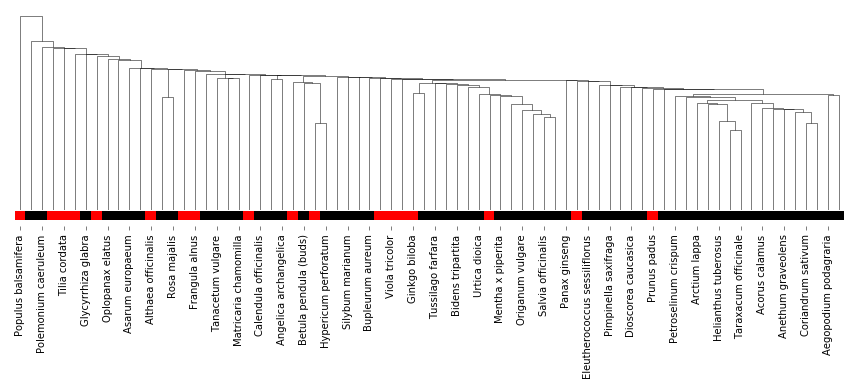

method: single, metric=correlation


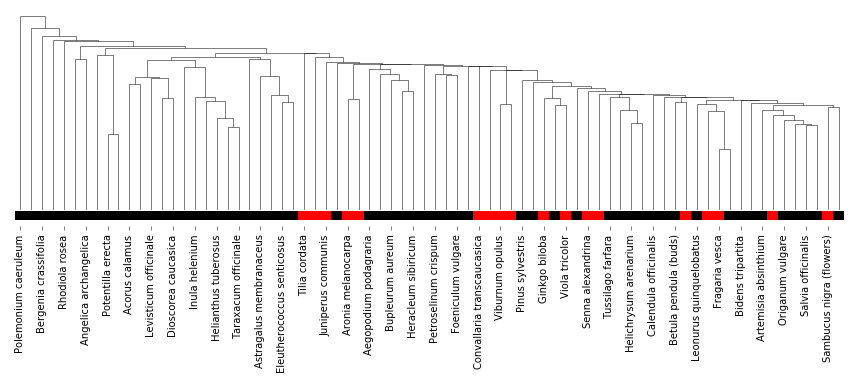

method: single, metric=cityblock


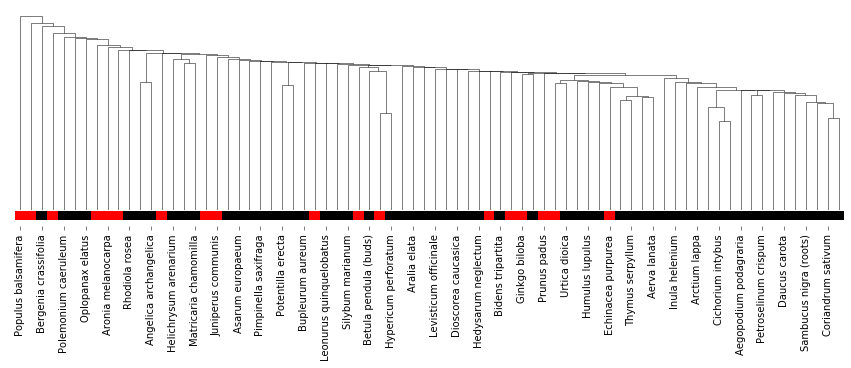

method: single, metric=cosine


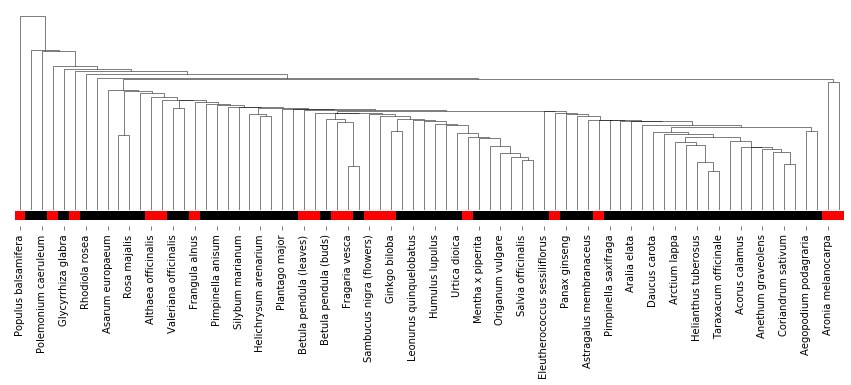

method: single, metric=chebyshev


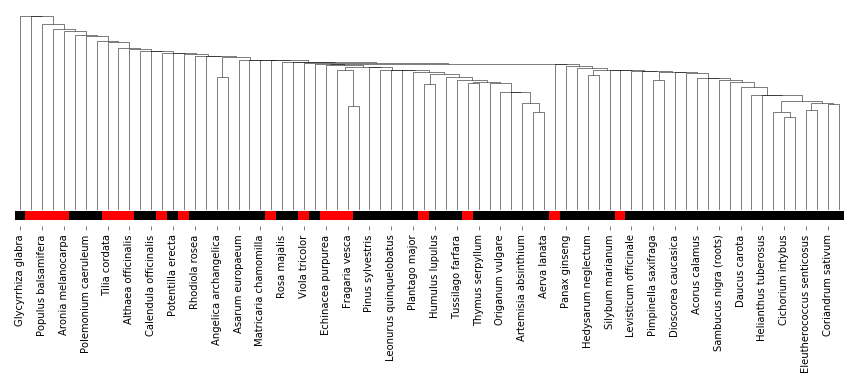

method: single, metric=canberra


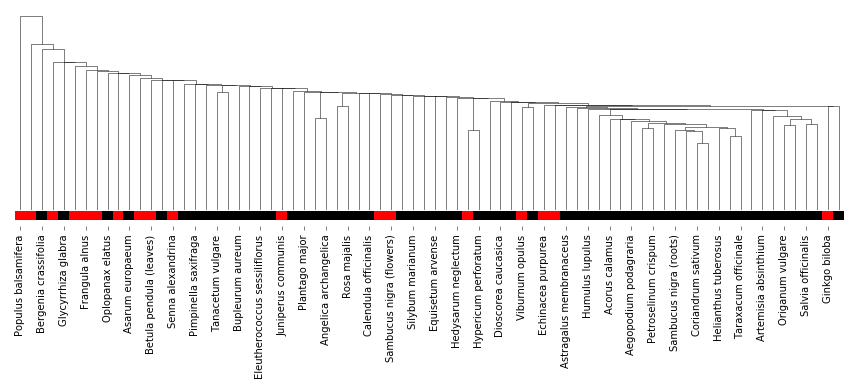

method: single, metric=braycurtis


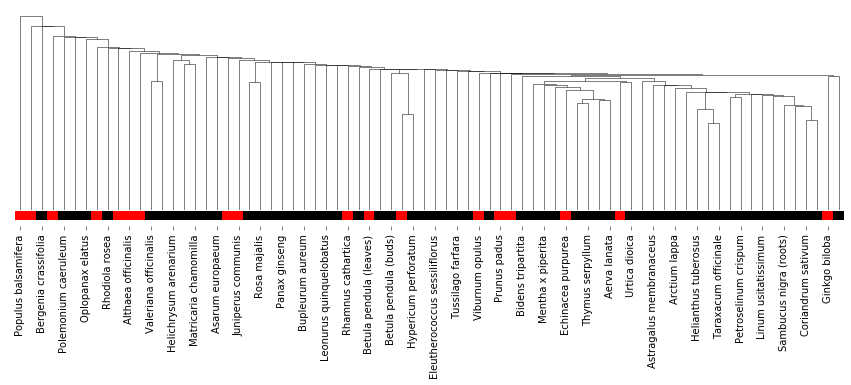

method: complete, metric=euclidean


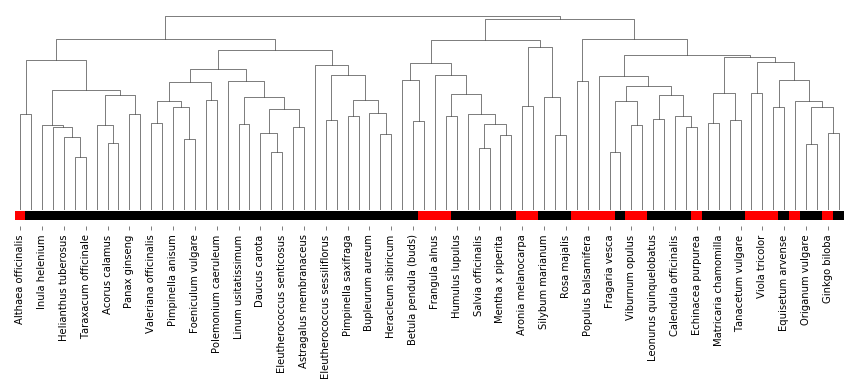

method: complete, metric=correlation


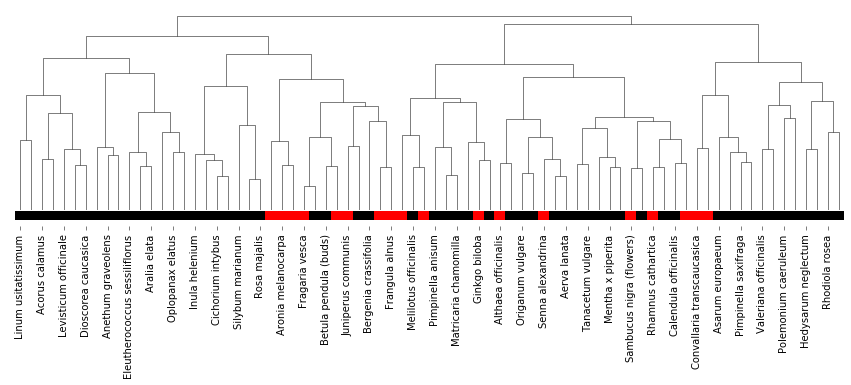

method: complete, metric=cityblock


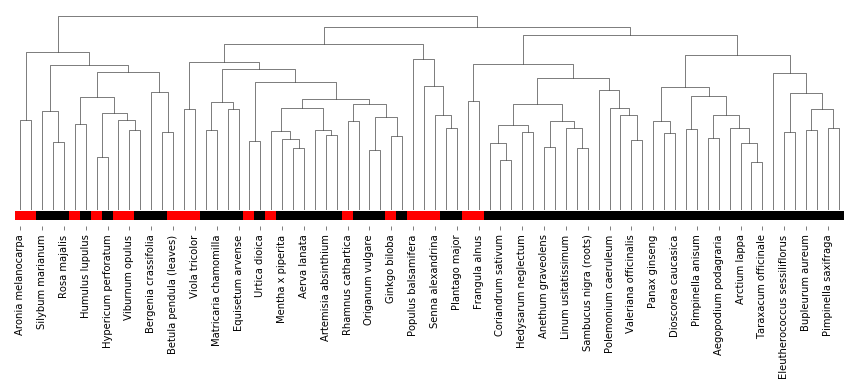

method: complete, metric=cosine


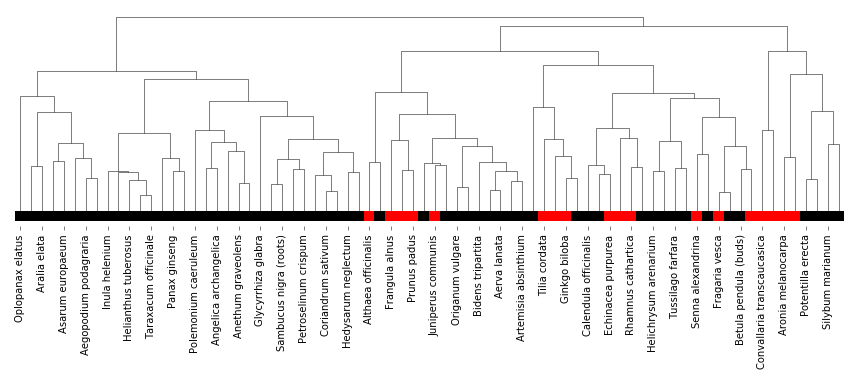

method: complete, metric=chebyshev


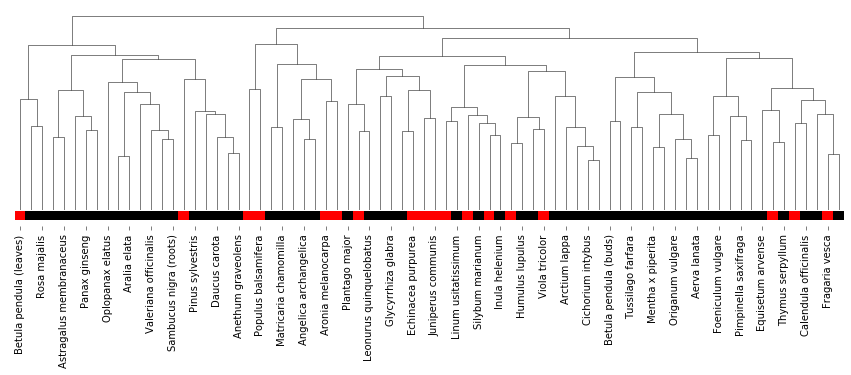

method: complete, metric=canberra


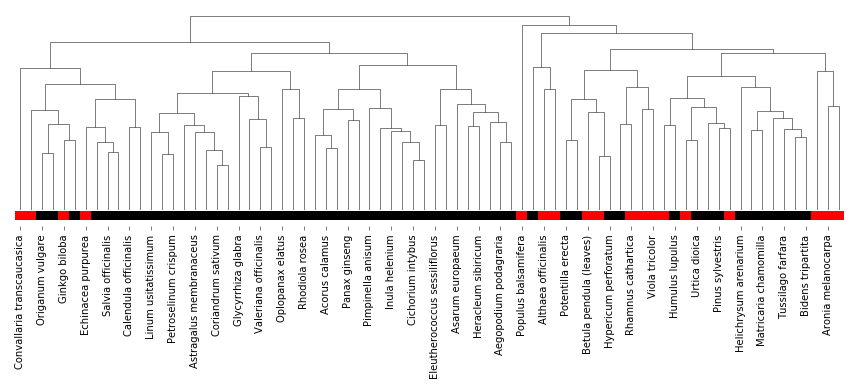

method: complete, metric=braycurtis


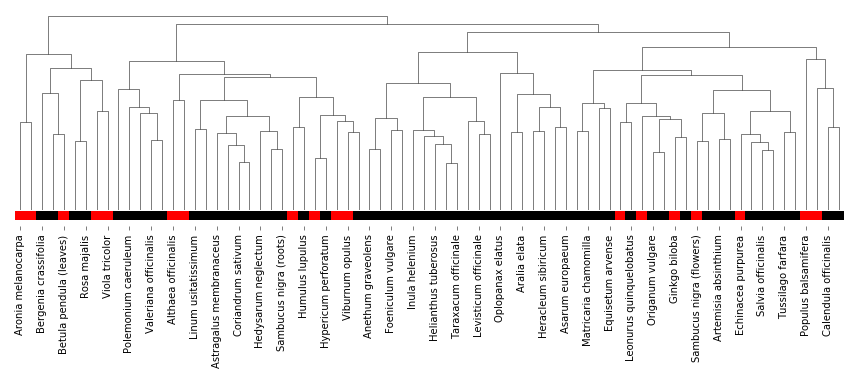

method: average, metric=euclidean


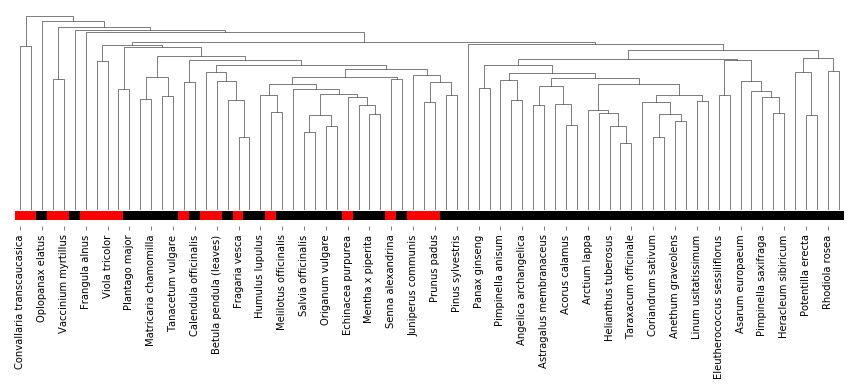

method: average, metric=correlation


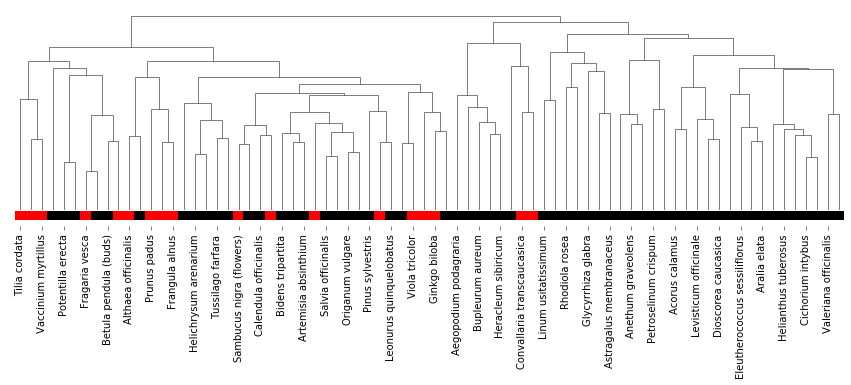

method: average, metric=cityblock


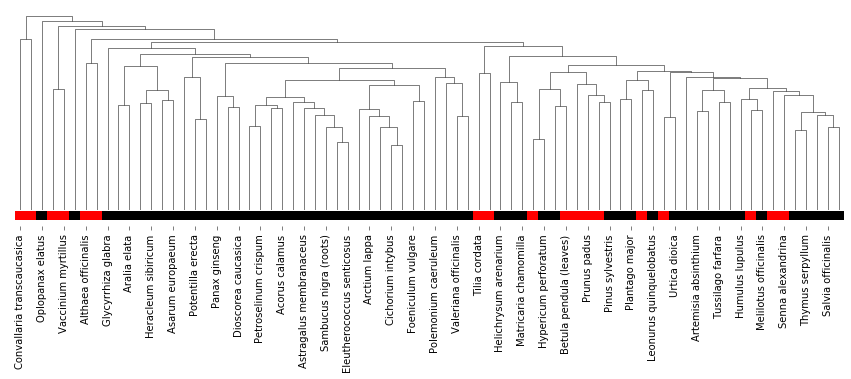

method: average, metric=cosine


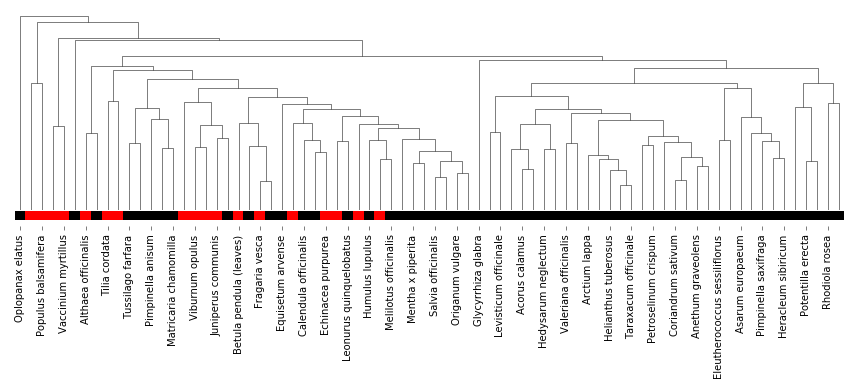

method: average, metric=chebyshev


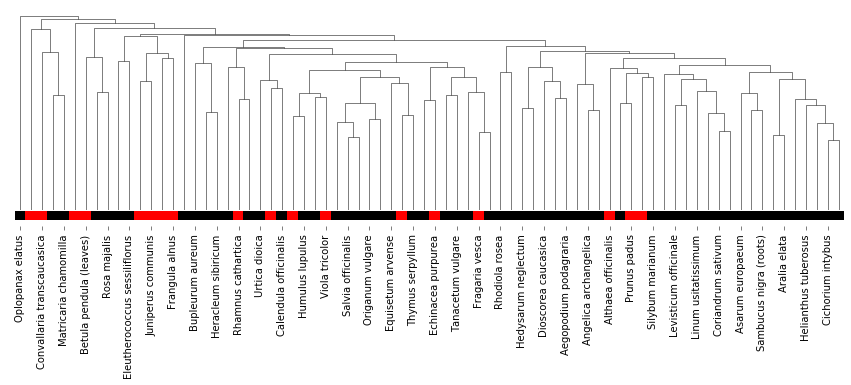

method: average, metric=canberra


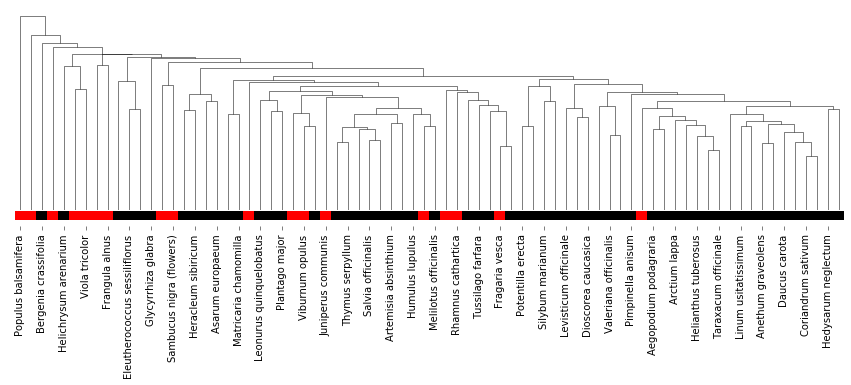

method: average, metric=braycurtis


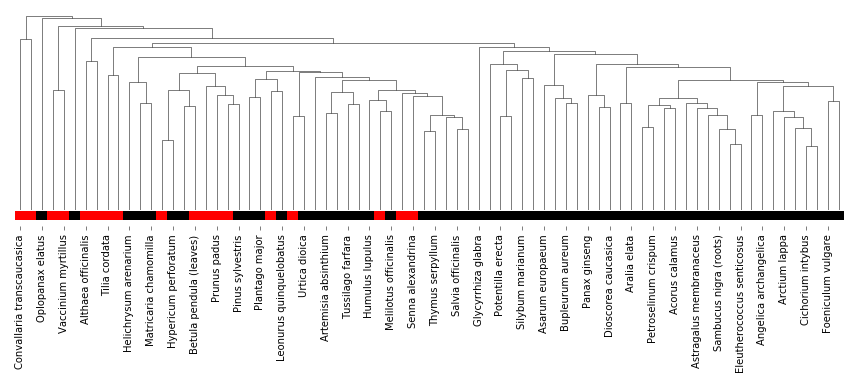

method: weighted, metric=euclidean


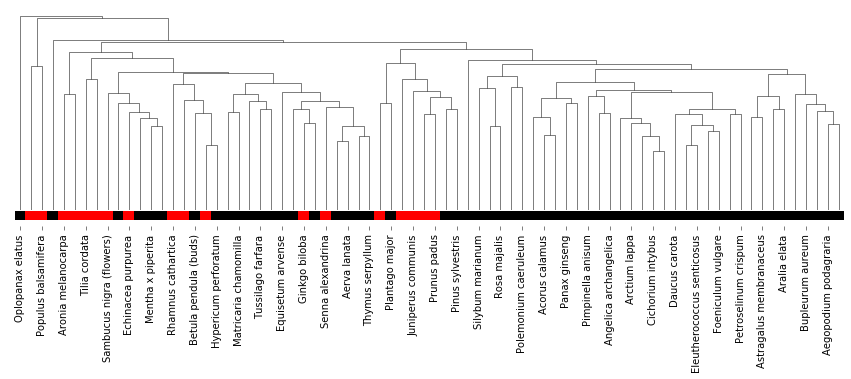

method: weighted, metric=correlation


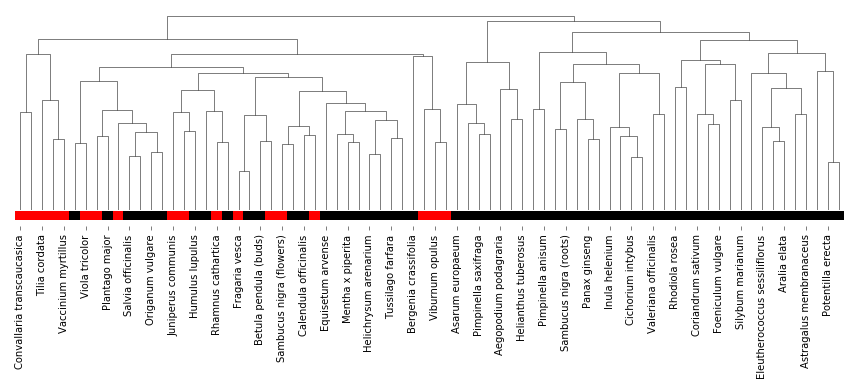

method: weighted, metric=cityblock


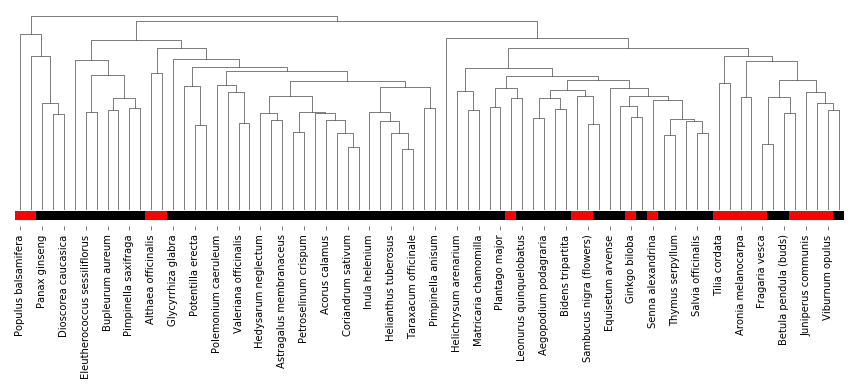

method: weighted, metric=cosine


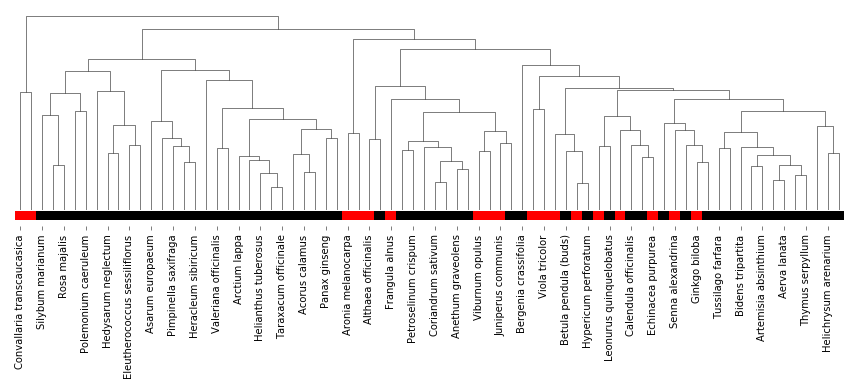

method: weighted, metric=chebyshev


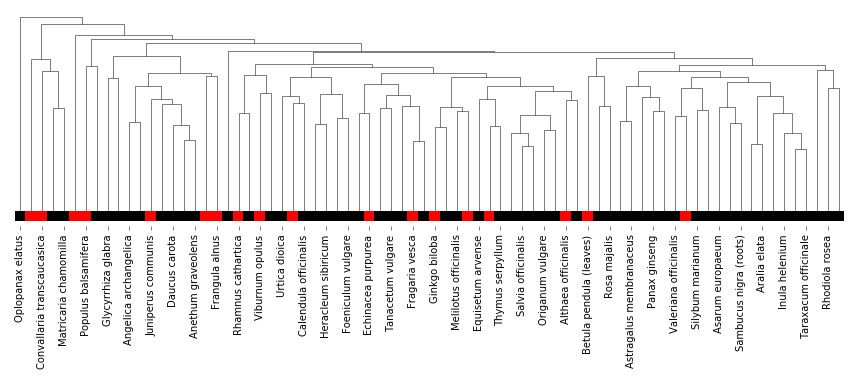

method: weighted, metric=canberra


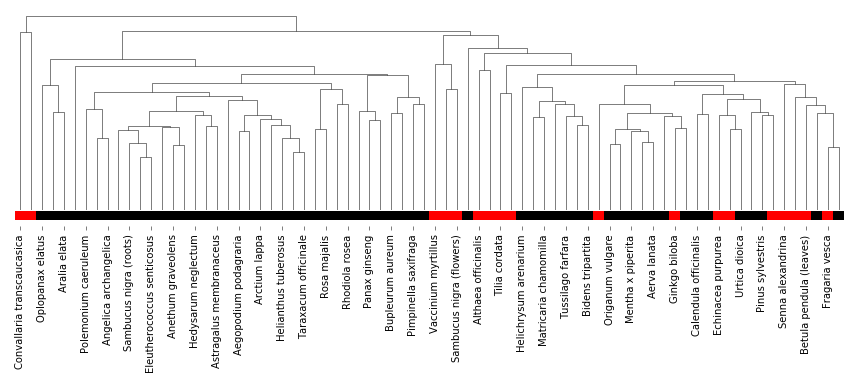

method: weighted, metric=braycurtis


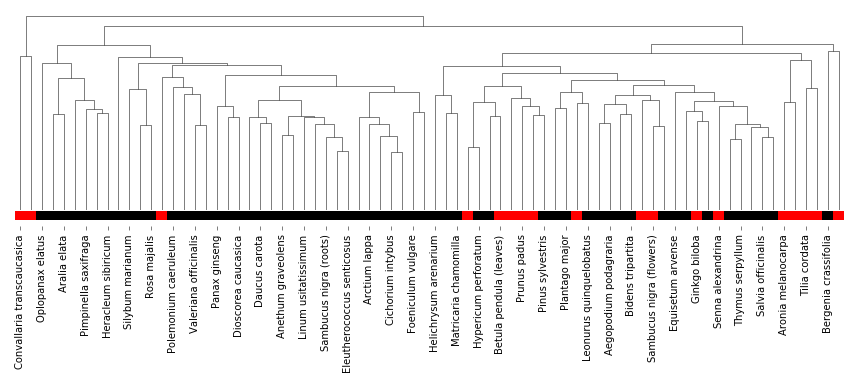

method: centroid, metric=euclidean


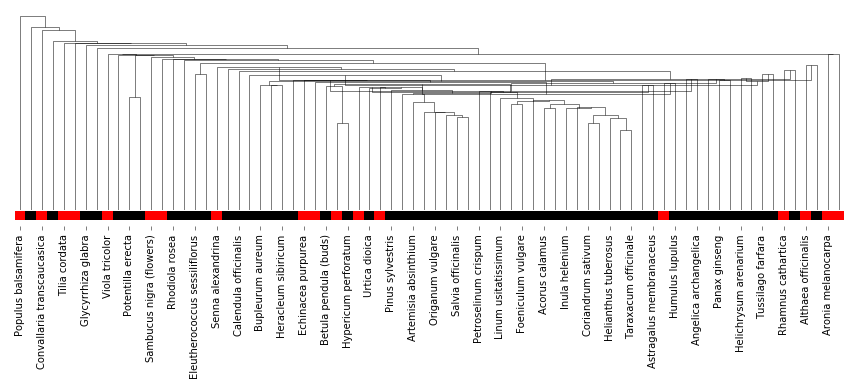

skipped metric=correlation for centroid
skipped metric=cityblock for centroid
skipped metric=cosine for centroid
skipped metric=chebyshev for centroid
skipped metric=canberra for centroid
skipped metric=braycurtis for centroid
method: median, metric=euclidean


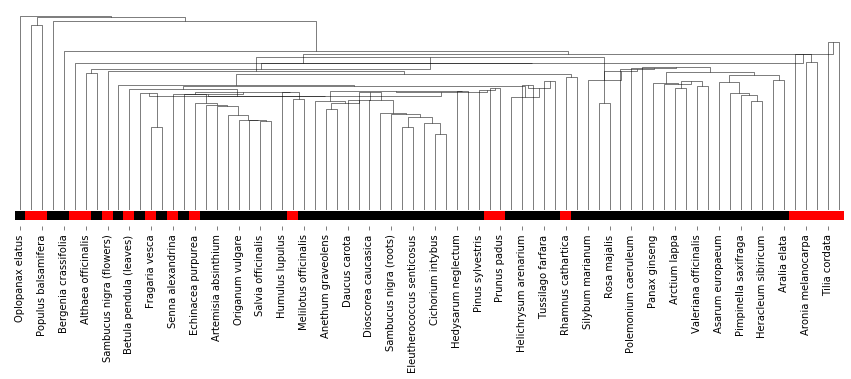

skipped metric=correlation for median
skipped metric=cityblock for median
skipped metric=cosine for median
skipped metric=chebyshev for median
skipped metric=canberra for median
skipped metric=braycurtis for median
method: ward, metric=euclidean


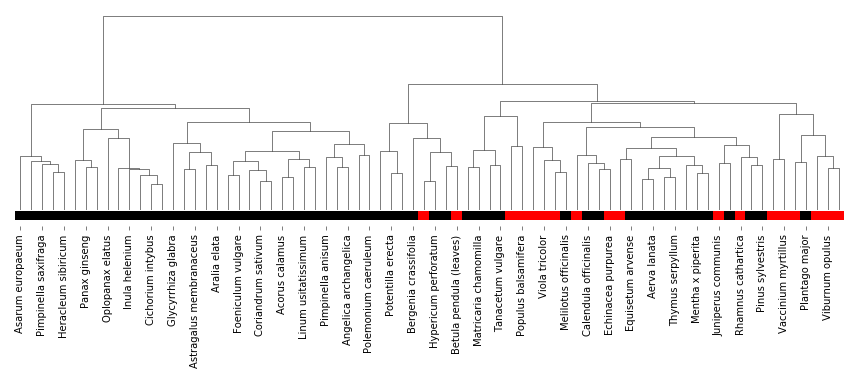

skipped metric=correlation for ward
skipped metric=cityblock for ward
skipped metric=cosine for ward
skipped metric=chebyshev for ward
skipped metric=canberra for ward
skipped metric=braycurtis for ward


In [4]:
plt.clf()
Y, Yae = [], []
uni_labels_named = []
for i in xrange(len(uni_labels)):
    current_label = uni_labels[i]
    ind = np.where(labels == current_label)[0]
    Y.append(
        np.mean(data[ind], axis=0)
    )
    Yae.append(
        np.mean(data_ae[ind], axis=0)
    )
    uni_labels_named.append( label_plant_dict[current_label] )
Y = np.array(Y)
Yae = np.array(Yae)
print Y.shape

pdY = pd.DataFrame(Y.T, columns=uni_labels_named, index=None)
pdYae = pd.DataFrame(Yae.T, columns=uni_labels_named, index=None)

metrics = [
    'euclidean',
    'correlation',
    'cityblock', 'cosine', 'chebyshev', 'canberra', 'braycurtis'
]

methods = [
    'single', 
    'complete', 
    'average', 'weighted', 'centroid', 'median', 'ward'
]

save_autoencoded = False
metric_to_save = 'correlation'
method_to_save = 'complete'
filename_save = 'hca_' + metric_to_save + '_' + method_to_save + '_' + str(int(save_autoencoded)) + '.pgf'

for i_met in xrange(len(methods)):
    method = methods[i_met]
    for i_metr in xrange(len(metrics)):
        metric = metrics[i_metr]
        if ((method == 'centroid') or (method == 'median') or (method == 'ward')) and (metric != 'euclidean'):
            print "skipped metric=%s for %s" % (metric, method)
            continue
        print 'method: %s, metric=%s' % (method, metric)
        i_cur = 0
        for current_pd in [pdYae]:
            cm = sns.clustermap(
                current_pd, pivot_kws=None, method=method,
                metric=metric, z_score=None, standard_scale=None,
                figsize=(15, 4), cbar_kws=None, row_cluster=False, col_cluster=True,
                row_linkage=None, col_linkage=None, row_colors=None,
                col_colors=text_column_colors,
                mask=np.ones(current_pd.values.shape), cmap="mako"
            )

            
            #cm.fig.delaxes(cm.fig.axes[-2])
            cm.fig.delaxes(cm.fig.axes[-1])
            #cm.fig.axes[-1].xaxis.set_visible(False)
            cm.fig.axes[-1].yaxis.set_visible(False)
            #cm.fig.axes[-1].set_frame_on(False)
            cm.gs.set_height_ratios([0.12, 0.1, 0.01, 0.01])
            cm.gs.set_width_ratios([0.001, 0.001, 0.8])
            cm.gs.update()
            if (metric == metric_to_save) and (method == method_to_save) and (i_cur == save_autoencoded):
                plt.savefig(filename_save, bbox_inches='tight')
            plt.show()
            #plt.gcf().subplots_adjust(bottom=0.15)
            
            i_cur += 1
        print '======================================================================================='



Colour legend for species.

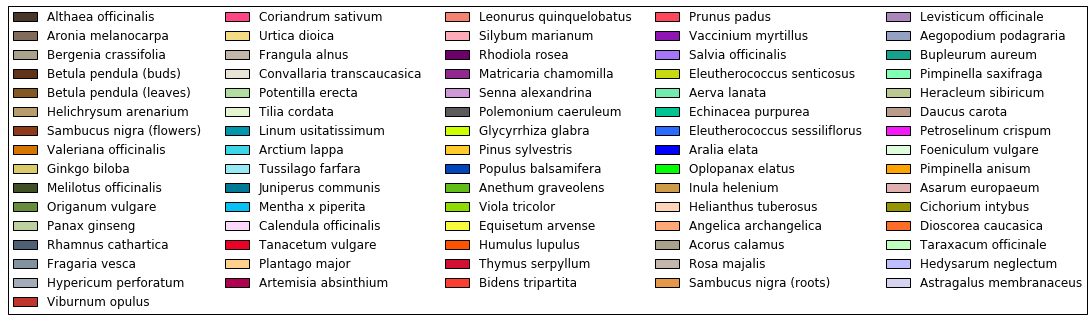

In [5]:
filename = 'colour_palette_76'
extension = 'pgf'
figleg = plt.figure()
legend_elements = [
    Patch(facecolor=species_dict[x], label='%s' % (label_plant_dict[x]))
    for x in species_dict.keys()
]
# Create the figure
ax_leg = figleg.add_subplot(111)
figleg.legend(handles=legend_elements, labels=uni_labels_named, ncol=5)
ax_leg.xaxis.set_visible(False)
ax_leg.yaxis.set_visible(False)
ax_leg.set_frame_on(False)
plt.savefig(filename+'.'+extension, bbox_inches='tight')
plt.show()


Clustering for samples. As in one of cells above, for a given pair of parameters (linkage, metric) the first and the second plots display clustering results on original and autoencoded feature spaces.

method: single, metric=euclidean


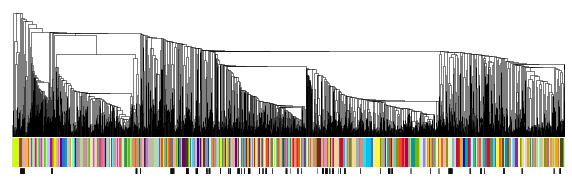

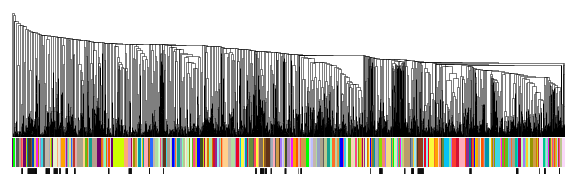

method: single, metric=correlation


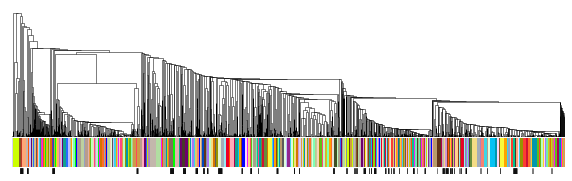

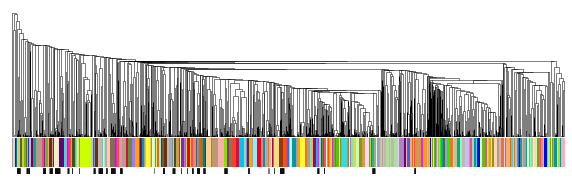

method: single, metric=cityblock


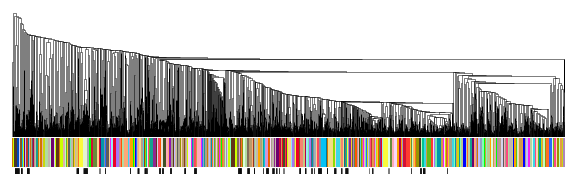

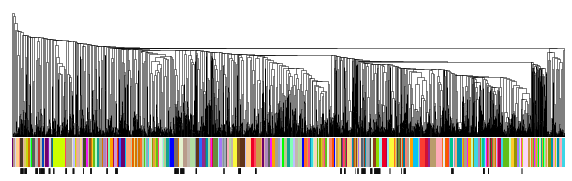

method: single, metric=cosine


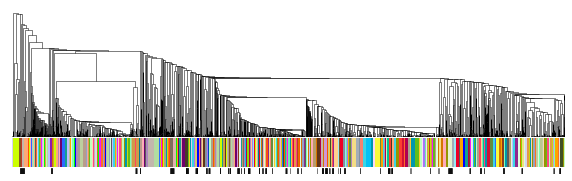

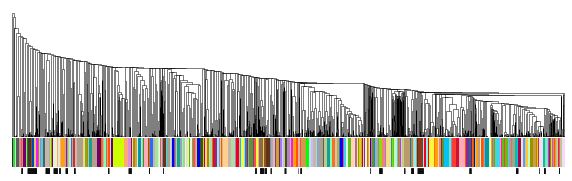

method: single, metric=chebyshev


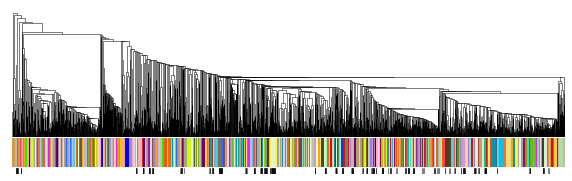

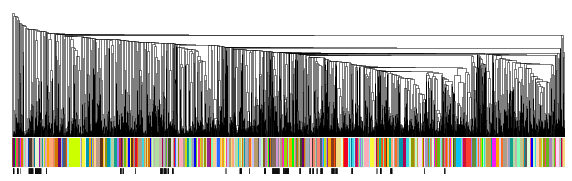

method: single, metric=canberra


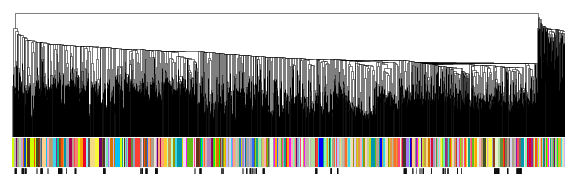

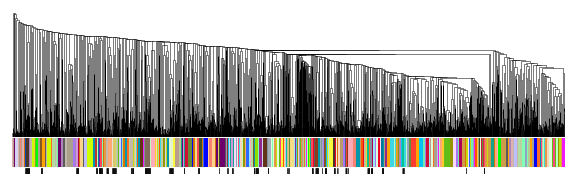

method: single, metric=braycurtis


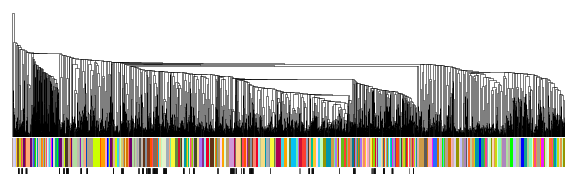

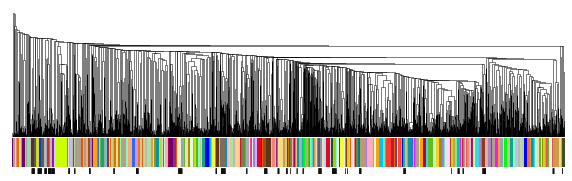

method: complete, metric=euclidean


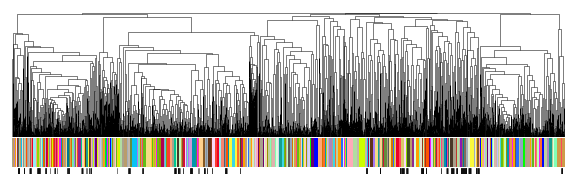

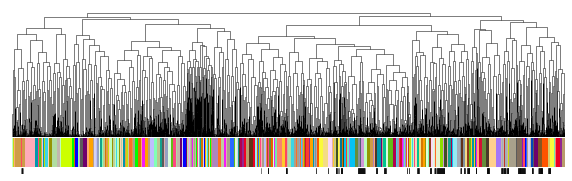

method: complete, metric=correlation


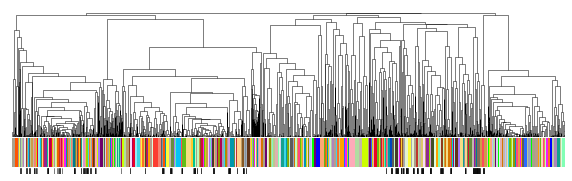

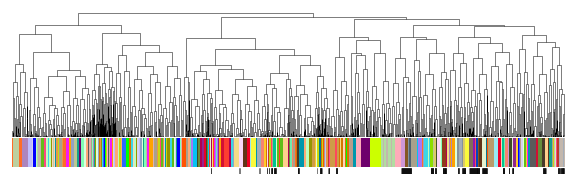

method: complete, metric=cityblock


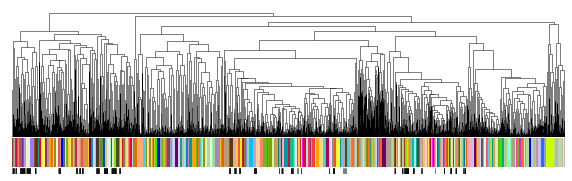

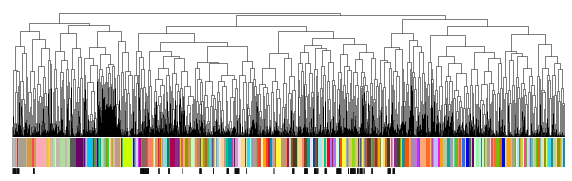

method: complete, metric=cosine


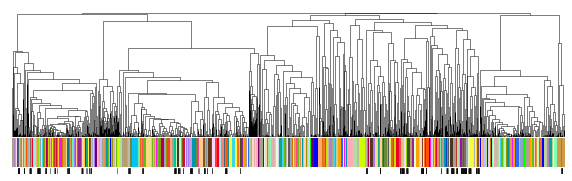

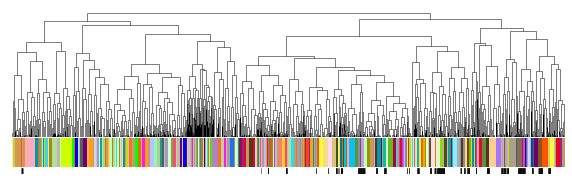

method: complete, metric=chebyshev


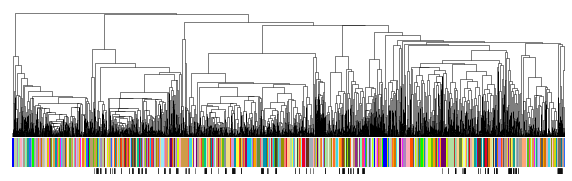

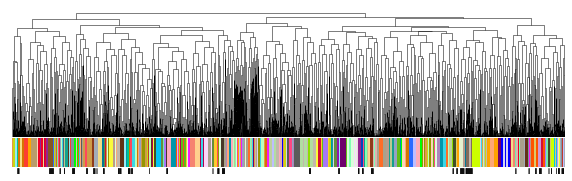

method: complete, metric=canberra


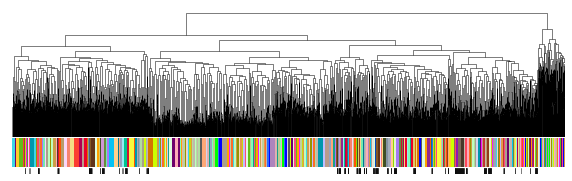

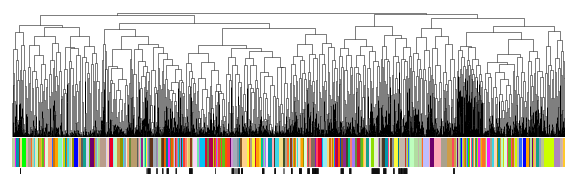

method: complete, metric=braycurtis


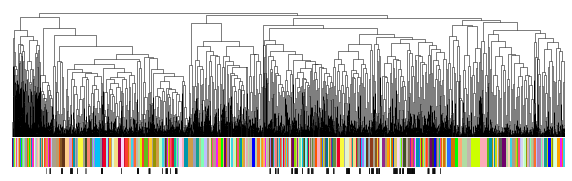

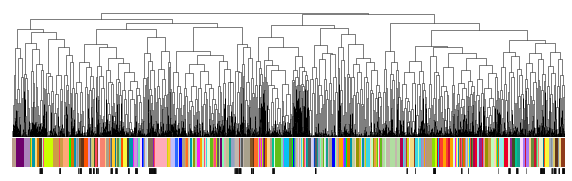

method: average, metric=euclidean


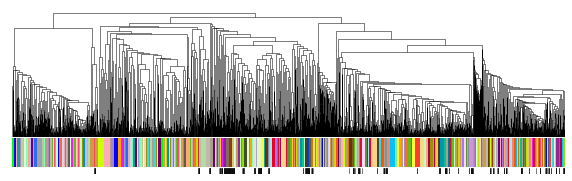

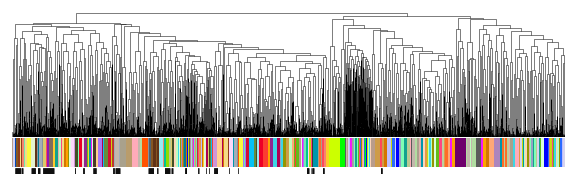

method: average, metric=correlation


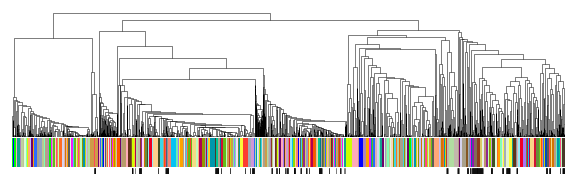

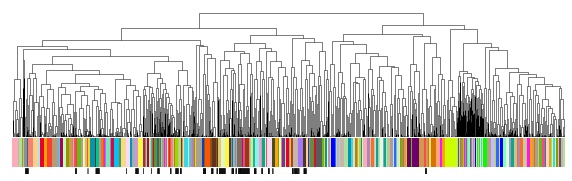

method: average, metric=cityblock


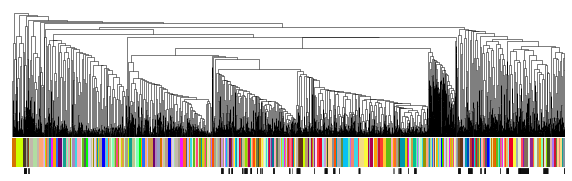

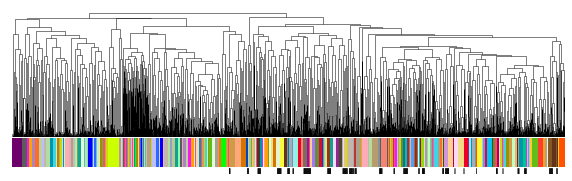

method: average, metric=cosine


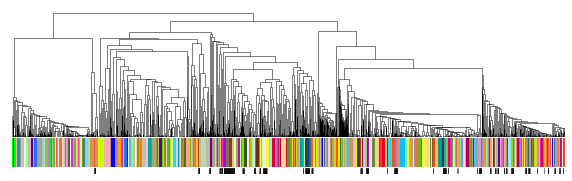

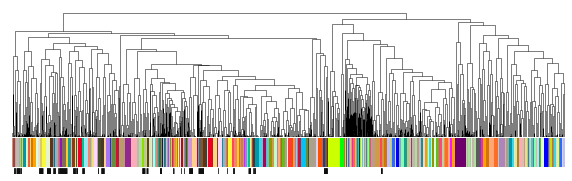

method: average, metric=chebyshev


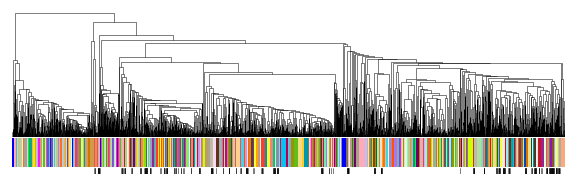

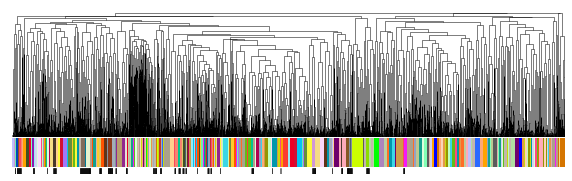

method: average, metric=canberra


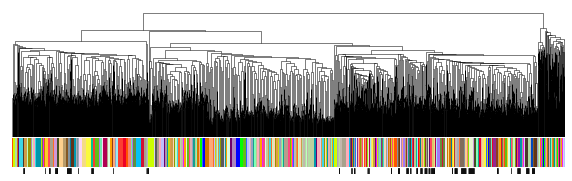

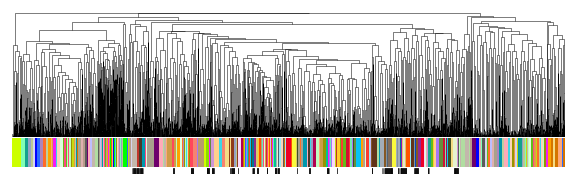

method: average, metric=braycurtis


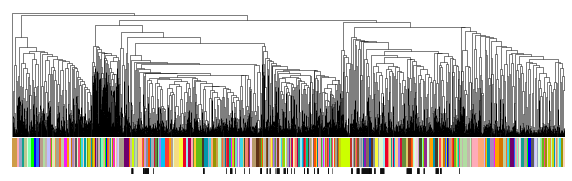

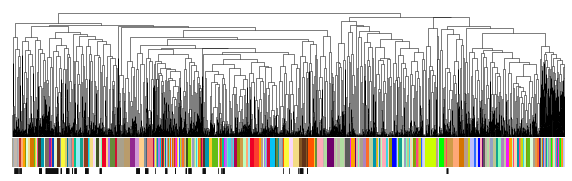

method: weighted, metric=euclidean


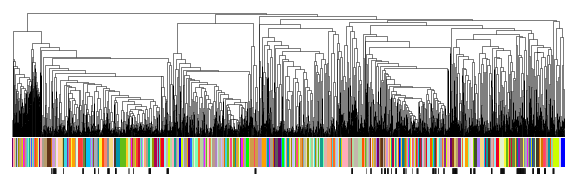

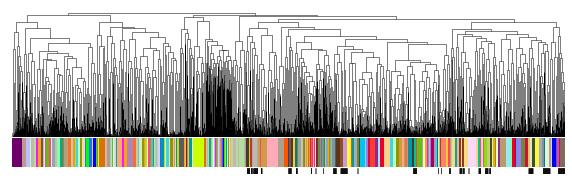

method: weighted, metric=correlation


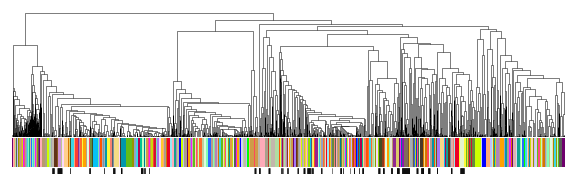

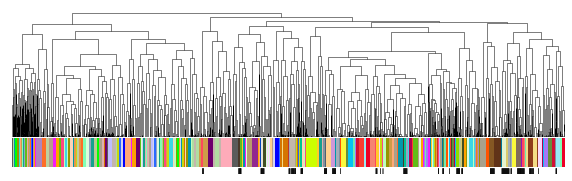

method: weighted, metric=cityblock


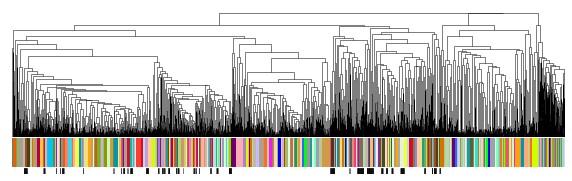

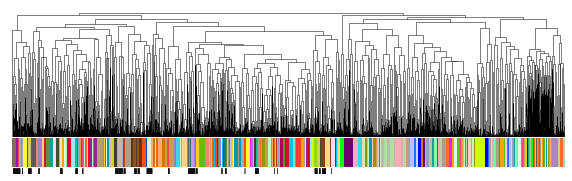

method: weighted, metric=cosine


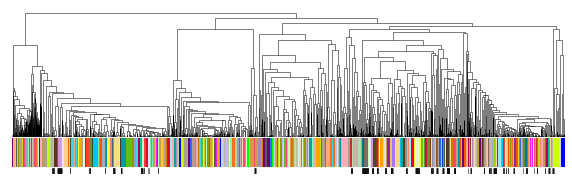

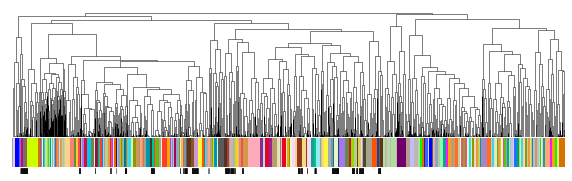

method: weighted, metric=chebyshev


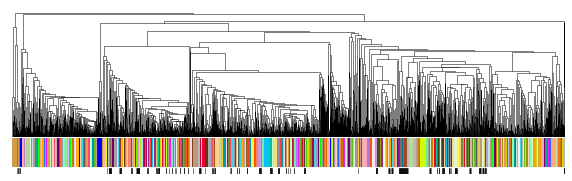

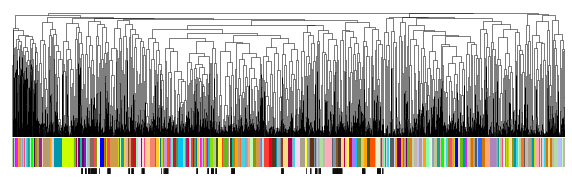

method: weighted, metric=canberra


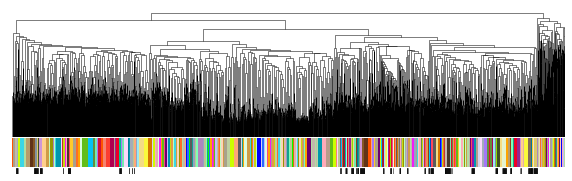

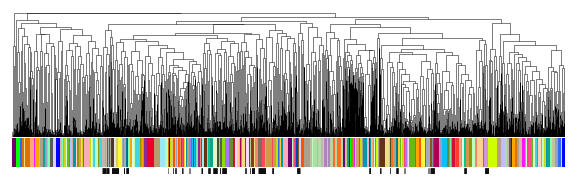

method: weighted, metric=braycurtis


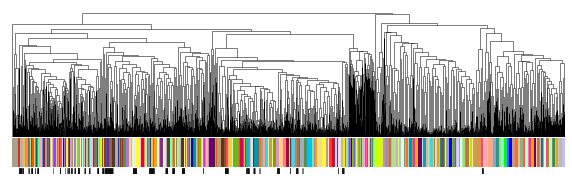

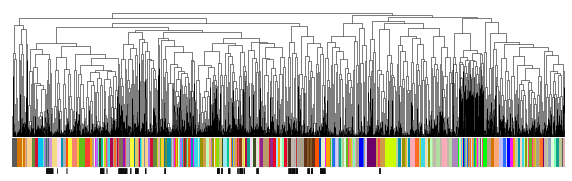

method: centroid, metric=euclidean


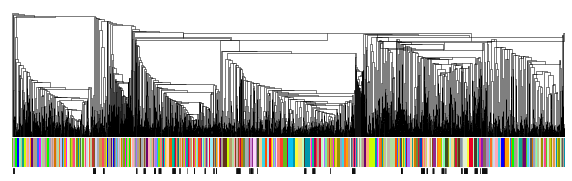

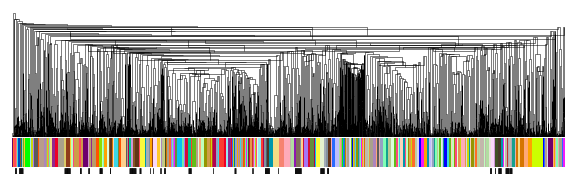

skipped metric=correlation for centroid
skipped metric=cityblock for centroid
skipped metric=cosine for centroid
skipped metric=chebyshev for centroid
skipped metric=canberra for centroid
skipped metric=braycurtis for centroid
method: median, metric=euclidean


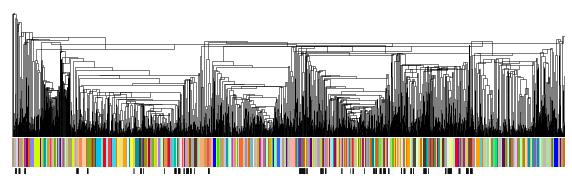

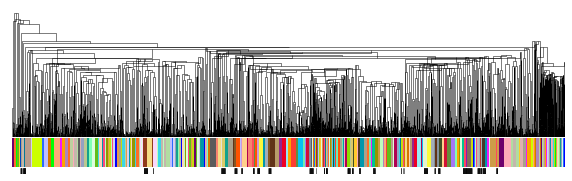

skipped metric=correlation for median
skipped metric=cityblock for median
skipped metric=cosine for median
skipped metric=chebyshev for median
skipped metric=canberra for median
skipped metric=braycurtis for median
method: ward, metric=euclidean


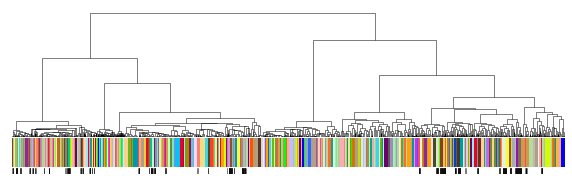

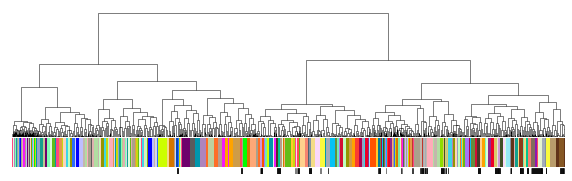

skipped metric=correlation for ward
skipped metric=cityblock for ward
skipped metric=cosine for ward
skipped metric=chebyshev for ward
skipped metric=canberra for ward
skipped metric=braycurtis for ward


In [5]:
plt.clf()
species_dict = dict(zip(uni_labels, sns.color_palette(colour_palette, len(uni_labels))))
column_colors = map(lambda x: species_dict[x], labels)
labels_named = map(lambda x: label_plant_dict[x], labels)

metrics = [
    'euclidean',
    'correlation', 'cityblock', 'cosine', 'chebyshev', 'canberra', 'braycurtis'
]

methods = [
    'single', 'complete', 'average',
    'weighted', 'centroid', 'median', 'ward'
]

metric_to_save = 'euclidean'
method_to_save = 'weighted'
filename_save = 'hca_all_' + metric_to_save + '_' + method_to_save + '_'
extension = 'pgf'

for i_met in xrange(len(methods)):
    method = methods[i_met]
    for i_metr in xrange(len(metrics)):
        metric = metrics[i_metr]
        if ((method == 'centroid') or (method == 'median') or (method == 'ward')) and (metric != 'euclidean'):
            print "skipped metric=%s for %s" % (metric, method)
            continue
        print 'method: %s, metric=%s' % (method, metric)

        i_cd = 0
        for current_data in [data, data_ae]:
            cm = sns.clustermap(
                current_data.T, pivot_kws=None, method=method,
                metric=metric, z_score=None, standard_scale=None,
                figsize=(10, 3), cbar_kws=None, row_cluster=False, col_cluster=True,
                row_linkage=None, col_linkage=None, row_colors=None, col_colors=column_colors,
                mask=np.ones(current_data.T.shape), cmap="mako"
            )


            cm.fig.delaxes(cm.fig.axes[-2])
            cm.fig.delaxes(cm.fig.axes[-1])
            #cm.fig.axes[-1].xaxis.set_visible(False)
            cm.fig.axes[-1].yaxis.set_visible(False)
            #cm.fig.axes[-1].set_frame_on(False)
            cm.gs.set_height_ratios([0.12, 0.1, 0.05, 0.01])
            cm.gs.set_width_ratios([0.001, 0.001, 0.8])
            
            nrows, ncols = cm.gs.get_geometry()
            ax_new = cm.fig.add_subplot(
                cm.gs[nrows - 1, ncols - 1]
            )
            
            #ax_new.set_xmargin(0)
            #ax_new.use_sticky_edges = False

            where_y = np.where(y[cm.dendrogram_col.reordered_ind] == -1)[0]
            for xc in where_y:
                ax_new.axvline(x=xc, color='black', linestyle='solid', linewidth=0.5)
            sns.utils.despine(ax=ax_new)
            ax_new.xaxis.set_visible(False)
            ax_new.yaxis.set_visible(False)
            ax_new.set_xlim(0, current_data.shape[0])
            ax_new.set_frame_on(False)
            
            cm.gs.update()
            plt.savefig(filename_save+str(i_cd)+'.'+extension, bbox_inches='tight')
            plt.show()
            i_cd += 1
        print '======================================================================================='


## 5. t-SNE plots

Cell below demonstrates how autoencoded features fascilitate species distinguishing. Left: original feature space (1600 variables); Right: autoencoded latent space (25 variables).

In [ ]:
from sklearn.manifold import TSNE

perplexities = [
    2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50
]

plt.clf()
for i_perp in xrange(len(perplexities)):
    perplexity = perplexities[i_perp]
    tsne = TSNE(
        n_components=2, perplexity=perplexity, early_exaggeration=12.0, learning_rate=200.0,
        n_iter=2000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean',
        init='random', verbose=0, random_state=None, method='exact'
    )
    print '================================================'
    print 'perplexity = %.1f' % (perplexity)
    tsneData = tsne.fit_transform(data)
    tsneDataAE = tsne.fit_transform(data_ae)
    np.savez_compressed('tsne_data_perp=%.1f' % (perplexity), tsneData=tsneData, tsneDataAE=tsneDataAE)
    print '================================================'

perplexity = 2.0


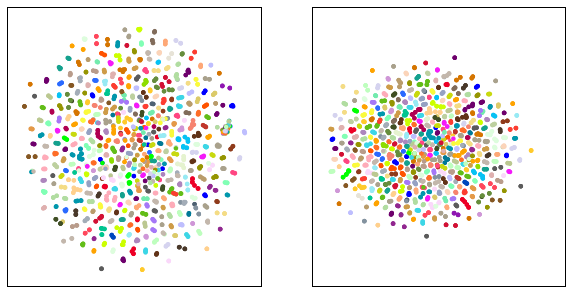

perplexity = 5.0


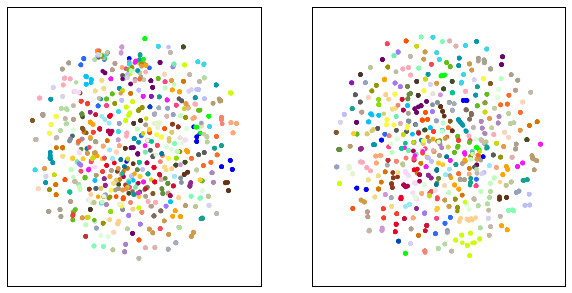

perplexity = 10.0


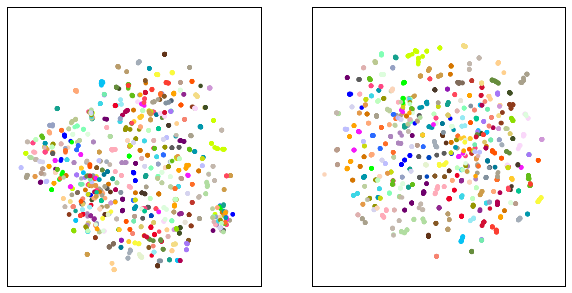

perplexity = 15.0


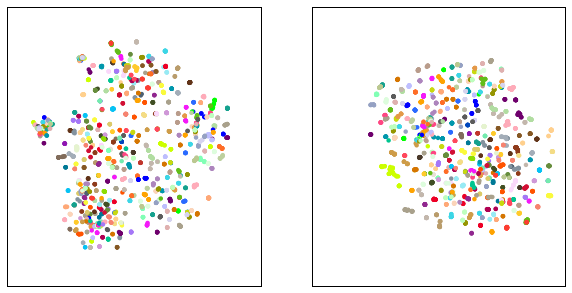

perplexity = 20.0


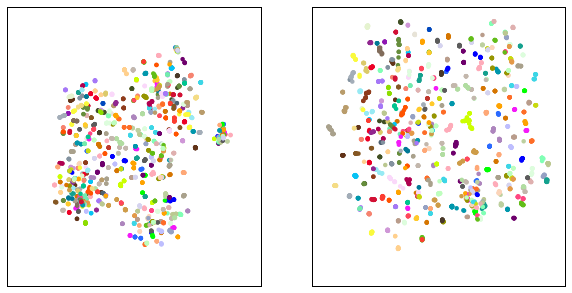

perplexity = 25.0


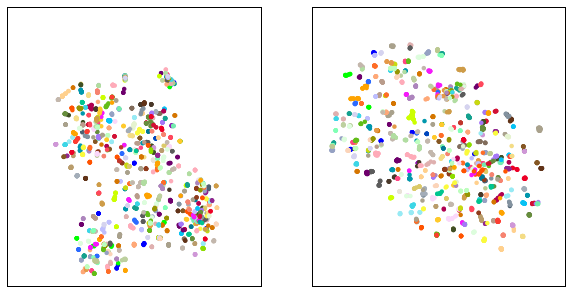

perplexity = 30.0


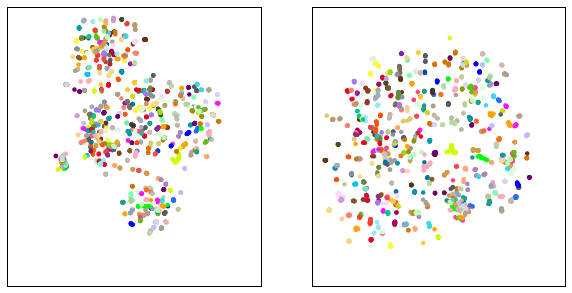

perplexity = 35.0


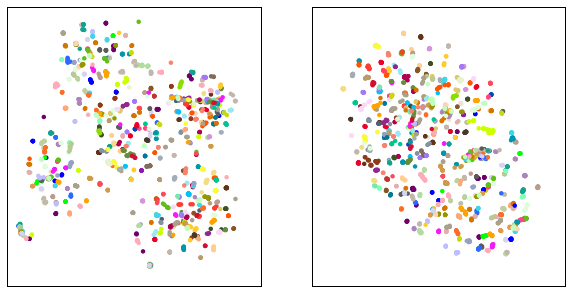

perplexity = 40.0


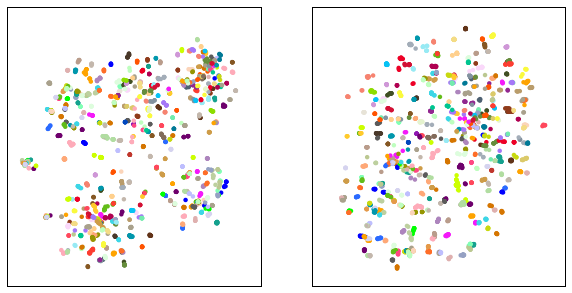

perplexity = 45.0


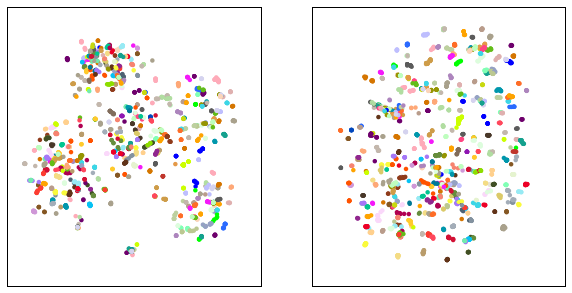

perplexity = 50.0


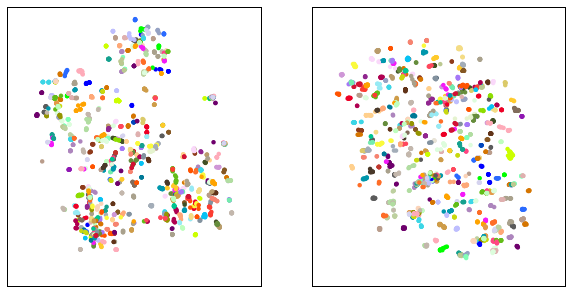

In [6]:
perplexities = [
    2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50
]

plt.clf()
for i_perp in xrange(len(perplexities)):
    perplexity = perplexities[i_perp]
    df = np.load('tsne_data_perp=%.1f.npz' % (perplexity))
    tsneData = df['tsneData']
    tsneDataAE = df['tsneDataAE']
    print '================================================'
    print 'perplexity = %.1f' % (perplexity)
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(
        tsneData[:, 0], tsneData[:, 1], c=column_colors, marker='o', edgecolors='none'
        #fillstyle='full', markeredgewidth=0.0
    )
    ax[0].xaxis.set_visible(False)
    ax[0].yaxis.set_visible(False)
    ax[1].scatter(
        tsneDataAE[:, 0], tsneDataAE[:, 1], c=column_colors, marker='o', edgecolors='none'
        #fillstyle='full', markeredgewidth=0.0
    )
    ax[1].xaxis.set_visible(False)
    ax[1].yaxis.set_visible(False)
    
    plt.show()
    print '================================================'